# Numba Demo 2

## Fibonacci Series

Lets try with the classic Fibonacci series:

$$f(x) = \begin{cases}
         x               & {0 <= x <= 1}\\
         f(x-1) + f(x-2) & x > 1
         \end{cases}$$
         
It's quite easy to convert it to pure Python code.

In [1]:
def fibonacci_r(x):
    assert x >= 0, 'x must be a positive integer'
    
    if x <= 1:  # First 2 cases.
        return x
        
    return fibonacci_r(x - 1) + fibonacci_r(x - 2)

X = [x for x in range(10)]
print('X = ' + repr(X))

Y = [fibonacci_r(x) for x in X]
print('Y = ' + repr(Y))

X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]


But the recursive implementation is not efficient, it is recursive, and at each recursion call itself twice:

$$O(n) = 2^{n}$$

Lets convert it to an iteractive function by memoizing former results at each iteration:

In [2]:
def fibonacci_i(x):
    assert x >= 0, 'x must be a positive integer'
    
    if x <= 1:  # First 2 cases.
        return x
    
    y_2 = 0
    y_1 = 1
    y_0 = 0
    for n in range(x - 1):
        y_0 = y_1 + y_2
        y_1, y_2 = y_0, y_1
        
    return y_0
        
X = [x for x in range(10)]
print('X = ' + repr(X))

Y = [fibonacci_i(x) for x in X]
print('Y = ' + repr(Y))

X = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34]


Iterative approach have a better CPU complexity:

$$O(n) = n$$

## Benchmark

Lets define a benchmark and use it to compare the two functions:

In [3]:
from IPython.display import display
from itertools import combinations
import time
import matplotlib
import os
import pandas as pd

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

# Different platforms require different functions to properly measure current timestamp:
if os.name == 'nt':
    now = time.clock
else:
    now = time.time

def run_benchmarks(minX, maxX, step=1, num_runs=10, functions=None):
    assert functions, 'Please pass a sequence of functions to be tested'
    assert num_runs > 0, 'Number of runs must be strictly positive'
    
    def _name(function):
        return '${%s(x)}$' % function.__name__
    
    def _measure(x, function):
        T_0 = now()
        for i in range(num_runs):
            function(x)
        return (now() - T_0) / num_runs
    
    df = pd.DataFrame()
    for function in functions:
        function(minX)  # This is necessary to let JIT produce the native function.
        X = [x
             for x in range(minX, maxX + 1, step)]
        Y = [_measure(x, function) for x in X]
        df[_name(function)] = pd.Series(data=Y, index=X)
        
    plt.figure()
    df.plot(figsize=(10,5),
            title='$y=Log_{10}(T[f(x)])$',
            style='o-',
            logy=True)
    
    if len(functions) >= 2:
        comb = combinations(((_name(function), df[_name(function)].values)
                             for function in functions), 2)
        for (nameA, timesA), (nameB, timesB) in comb:
            title = '$y=\\frac{T[%s]}{T[%s]}$' % (nameA[1:-1], nameB[1:-1])
            plt.figure()
            (df[nameA] / df[nameB]).plot(figsize=(10,3.5),
                                         title=title,
                                         style='o-')

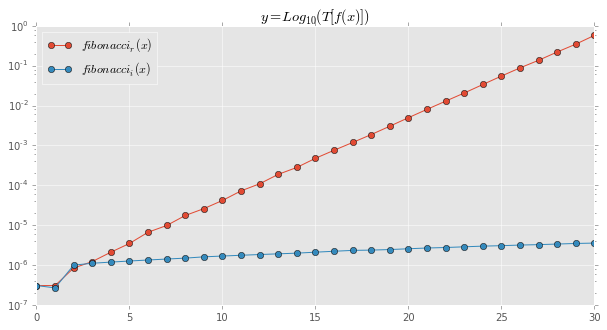

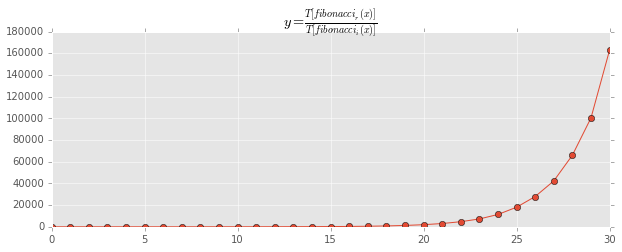

In [4]:
run_benchmarks(0, 30, functions=[fibonacci_r, fibonacci_i])

The iterative aproach, being linear, is already hundred thousand times faster for $x=30$

## Lets jit them up!

Lets try to apply JIT optimizations on both implementations:

In [5]:
from numba import jit

@jit
def fibonacciJit_r(x):
    assert x >= 0, 'x must be a positive integer'
    
    if x <= 1:  # First 2 cases.
        return x
        
    return fibonacciJit_r(x - 1) + fibonacciJit_r(x - 2)

@jit
def fibonacciJit_i(x):
    assert x >= 0, 'x must be a positive integer'
    
    if x <= 1:  # First 2 cases.
        return x
    
    y_2 = 0
    y_1 = 1
    y_0 = 0
    for n in range(x - 1):
        y_0 = y_1 + y_2
        y_1, y_2 = y_0, y_1
        
    return y_0

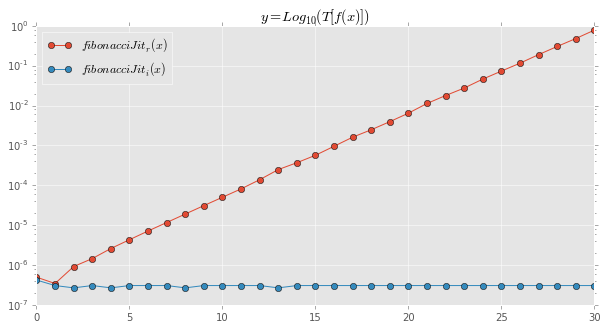

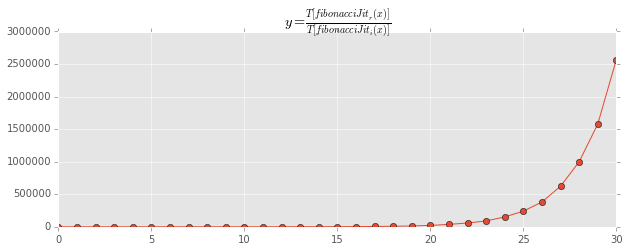

In [6]:
run_benchmarks(0, 30, functions=[fibonacciJit_r, fibonacciJit_i])

This means that an algorithmical optimization gives the same relative improvement being it compiled nativelly or not.

## Pure Python vs jitted:

Lets compare instead the optimized $fibonacci_i(x)$ against $fibonacciJit_i(x)$ just to see a row optimization (native, vs dynamic code) can improve things:

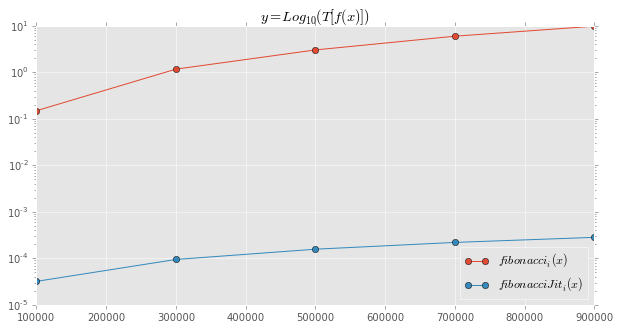

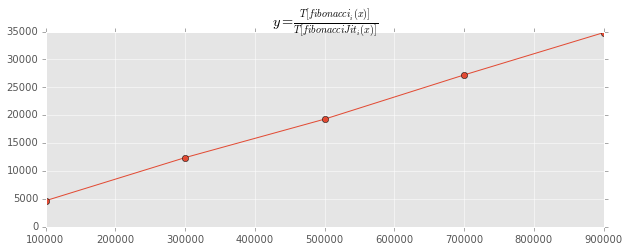

In [7]:
run_benchmarks(100000, 1000000, step=200000, num_runs=5, functions=[fibonacci_i, fibonacciJit_i])

The ration is not constant as expected, but increases with the number of iterations.

This may be related to the fact that dynamic implementation may be using dynamically allocated memory, something native implementation doesn't.

## Conclusions

- Algorithmical optimizations should be tried first because can give us incomparable speed benefits: $fibonacci_r(x)|_{x=30}$ already takes seconds to execute.

- Raw optimizations should come afterward, including native compilations, parallel execution...).